In [1]:
# !pip install scikit_posthocs
# !pip install --upgrade tensorflow keras
# !pip install --upgrade pip

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp


# Tokenization and padding sequences
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load IMDB dataset
df = pd.read_csv('data/IMDBDataset/IMDB_Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# Preprocessing text (remove)
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'<br\s*/?>', ' ', text)  # HTML tags like <br>
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # special characters and numbers
    words = word_tokenize(text)  # Tokenize the text
    # stop_words = set(stopwords.words('english'))
    # words = [word for word in words if word not in stop_words]  # stopwords
    return ' '.join(words)

df['processed_review'] = df['review'].apply(preprocess_text)

In [6]:
df.head()

,review,sentiment,processed_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


In [7]:
# Comprimento de cada review
df['review_length'] = df['processed_review'].apply(lambda x: len(x.split()))

print(f"Comprimento médio dos reviews: {df['review_length'].mean()}")
print(f"Comprimento mediano dos reviews: {df['review_length'].median()}")
print(f"Comprimento máximo dos reviews: {df['review_length'].max()}")

Comprimento médio dos reviews: 226.91556
Comprimento mediano dos reviews: 170.0
Comprimento máximo dos reviews: 2450


sentiment
positive    25000
negative    25000
Name: count, dtype: int64


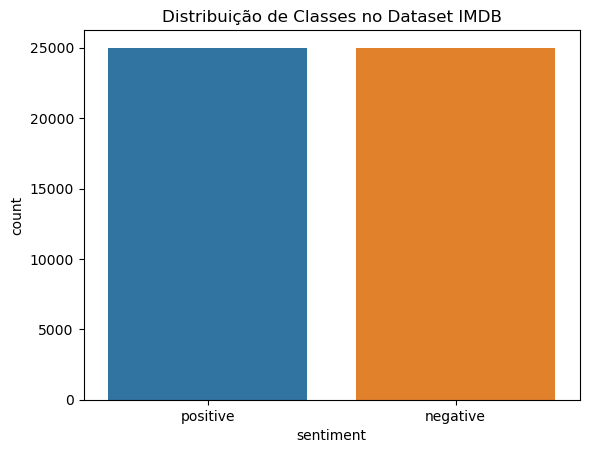

In [8]:
# Distribuição das classes

print(df['sentiment'].value_counts())
sns.countplot(x=df['sentiment'])  # eixo x
plt.title("Distribuição de Classes no Dataset IMDB")
plt.show()

In [9]:
# Preprocessing
X = df['processed_review']
y = df['sentiment']

In [10]:
# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
# Tokenization and padding sequences
tokenizer = Tokenizer(num_words=10000) 
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
max_len = 250  # Ajuste baseado na análise de comprimento
X = pad_sequences(X, padding='post', maxlen=max_len)

In [12]:
# Defining K-Fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# Definindo otimizadores
optimizers = {
    'Adam': (Adam, {'learning_rate': 0.001}),
    'RMSprop': (RMSprop, {'learning_rate': 0.001}),
    'SGD': (SGD, {'learning_rate': 0.001, 'momentum': 0.9}),
    'Adagrad': (Adagrad, {'learning_rate': 0.001})
}

In [14]:
# Dicionário para armazenar os resultados e predições
results = {model_name: {opt_name: {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'predictions': []} 
                        for opt_name in optimizers.keys()} 
           for model_name in ['model1', 'model2', 'model3']}

In [15]:
# Função para calcular e exibir as métricas de desempenho
def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print(f"Acurácia: {accuracy:.2f}")
    print(f"Precisão: {precision:.2f}")
    print(f"Revocação: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    return accuracy, precision, recall, f1

In [16]:
# Funções para criar as diferentes arquiteturas de redes neurais
def create_model1():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=100, input_length=250))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))  # Primeira camada densa
    model.add(Dense(1, activation='sigmoid'))  # Saída binária
    return model

def create_model2():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=100, input_length=250))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))  # Primeira camada densa
    model.add(Dense(32, activation='relu'))  # Segunda camada densa
    model.add(Dense(1, activation='sigmoid'))  # Saída binária
    return model

def create_model3():
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=100, input_length=250))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))  # Primeira camada densa
    model.add(Dense(32, activation='relu'))  # Segunda camada densa
    model.add(Dense(16, activation='relu'))  # Terceira camada densa
    model.add(Dense(1, activation='sigmoid'))  # Saída binária
    return model

In [17]:
# Loop de treinamento para otimizar as diferentes arquiteturas e otimizadores
for optimizer_name, (optimizer_class, optimizer_params) in optimizers.items():
    print(f"Treinando com {optimizer_name}")

    # Dividindo os dados com K-Fold
    for train_index, val_index in kfold.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        for idx, create_model in enumerate([create_model1, create_model2, create_model3]):
            print(f"Treinando Arquitetura {idx + 1} com {optimizer_name}")
            model = create_model()
            # Criar uma nova instância do otimizador para cada modelo
            optimizer = optimizer_class(**optimizer_params)
            
            # Compilação do modelo para classificação binária
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            
            # Treinamento
            history = model.fit(X_train, y_train, 
                                epochs=10,
                                batch_size=32, 
                                verbose=1, 
                                validation_data=(X_val, y_val))

            # Fazendo predições no conjunto de validação
            y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()

            # Cálculo e exibição das métricas de classificação usando a função `print_metrics`
            accuracy, precision, recall, f1 = print_metrics(y_val, y_pred)

            # Salvando os resultados e histórico
            model_name = f"model{idx + 1}"
            results[model_name][optimizer_name]['accuracy'].append(accuracy)
            results[model_name][optimizer_name]['precision'].append(precision)
            results[model_name][optimizer_name]['recall'].append(recall)
            results[model_name][optimizer_name]['f1'].append(f1)
            results[model_name][optimizer_name]['predictions'].append((y_val, y_pred))
            results[model_name][optimizer_name]['history'] = history.history

            print(f"\nFold Resultados ({optimizer_name} - Arquitetura {idx + 1}):")
            print(f"Acurácia: {accuracy:.4f}")
            print(f"Precisão: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")

Treinando com Adam
Treinando Arquitetura 1 com Adam


C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7346 - loss: 0.5068 - val_accuracy: 0.8842 - val_loss: 0.2852
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8878 - loss: 0.2641 - val_accuracy: 0.8872 - val_loss: 0.2741
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9114 - loss: 0.2234 - val_accuracy: 0.8661 - val_loss: 0.3170
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9168 - loss: 0.2124 - val_accuracy: 0.8843 - val_loss: 0.2808
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9229 - loss: 0.1965 - val_accuracy: 0.8619 - val_loss: 0.3509
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9288 - loss: 0.1839 - val_accuracy: 0.8867 - val_loss: 0.2894
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9378 - loss: 0.1659 - val_accuracy: 0.8848 - val_loss: 0.2968
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9403 -

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7298 - loss: 0.5005 - val_accuracy: 0.8844 - val_loss: 0.2795
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8961 - loss: 0.2582 - val_accuracy: 0.8861 - val_loss: 0.2727
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9100 - loss: 0.2271 - val_accuracy: 0.8876 - val_loss: 0.2663
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9193 - loss: 0.2038 - val_accuracy: 0.8637 - val_loss: 0.3233
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9214 - loss: 0.1970 - val_accuracy: 0.8877 - val_loss: 0.2752
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9333 - loss: 0.1737 - val_accuracy: 0.8069 - val_loss: 0.5077
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9359 - loss: 0.1638 - val_accuracy: 0.8860 - val_loss: 0.3088
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9481 - loss: 0.13

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7189 - loss: 0.5137 - val_accuracy: 0.8837 - val_loss: 0.2874
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8978 - loss: 0.2550 - val_accuracy: 0.8785 - val_loss: 0.2864
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9094 - loss: 0.2272 - val_accuracy: 0.8794 - val_loss: 0.2870
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9198 - loss: 0.2041 - val_accuracy: 0.8866 - val_loss: 0.2748
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9265 - loss: 0.1925 - val_accuracy: 0.8586 - val_loss: 0.3475
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9332 - loss: 0.1755 - val_accuracy: 0.8868 - val_loss: 0.3063
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9355 - loss: 0.1614 - val_accuracy: 0.8810 - val_loss: 0.3313
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9368 - loss: 0.15

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7233 - loss: 0.5156 - val_accuracy: 0.8820 - val_loss: 0.2888
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8942 - loss: 0.2572 - val_accuracy: 0.8850 - val_loss: 0.2822
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9029 - loss: 0.2391 - val_accuracy: 0.8695 - val_loss: 0.3010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9181 - loss: 0.2043 - val_accuracy: 0.8930 - val_loss: 0.2702
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9231 - loss: 0.1943 - val_accuracy: 0.8657 - val_loss: 0.3185
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9256 - loss: 0.1897 - val_accuracy: 0.8832 - val_loss: 0.3031
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9366 - loss: 0.1684 - val_accuracy: 0.8886 - val_loss: 0.3092
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9387 - loss: 0.15

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.7374 - loss: 0.4919 - val_accuracy: 0.8818 - val_loss: 0.2806
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8868 - loss: 0.2688 - val_accuracy: 0.8691 - val_loss: 0.2983
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9093 - loss: 0.2272 - val_accuracy: 0.8745 - val_loss: 0.2953
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9186 - loss: 0.2059 - val_accuracy: 0.8890 - val_loss: 0.2753
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9241 - loss: 0.1960 - val_accuracy: 0.8821 - val_loss: 0.2896
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9296 - loss: 0.1815 - val_accuracy: 0.8891 - val_loss: 0.2967
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9386 - loss: 0.1622 - val_accuracy: 0.8877 - val_loss: 0.3157
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9448 - loss: 0.14

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7331 - loss: 0.4932 - val_accuracy: 0.8797 - val_loss: 0.2956
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8860 - loss: 0.2768 - val_accuracy: 0.8727 - val_loss: 0.2990
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.9133 - loss: 0.2194 - val_accuracy: 0.8760 - val_loss: 0.2905
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9188 - loss: 0.2050 - val_accuracy: 0.8811 - val_loss: 0.2870
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9228 - loss: 0.1957 - val_accuracy: 0.8864 - val_loss: 0.2867
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9349 - loss: 0.1665 - val_accuracy: 0.8865 - val_loss: 0.3076
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.9404 - loss: 0.1563 - val_accuracy: 0.8808 - val_loss: 0.3628
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9486 - loss: 0.13

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7281 - loss: 0.5123 - val_accuracy: 0.8861 - val_loss: 0.2848
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8972 - loss: 0.2538 - val_accuracy: 0.8816 - val_loss: 0.2830
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9092 - loss: 0.2282 - val_accuracy: 0.8768 - val_loss: 0.2922
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9190 - loss: 0.2036 - val_accuracy: 0.8779 - val_loss: 0.3059
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9277 - loss: 0.1889 - val_accuracy: 0.8838 - val_loss: 0.2851
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9326 - loss: 0.1757 - val_accuracy: 0.8816 - val_loss: 0.2973
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9374 - loss: 0.1690 - val_accuracy: 0.8793 - val_loss: 0.3098
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9403 - loss: 0.16

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7370 - loss: 0.5007 - val_accuracy: 0.8698 - val_loss: 0.3102
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8859 - loss: 0.2742 - val_accuracy: 0.8308 - val_loss: 0.3789
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9030 - loss: 0.2389 - val_accuracy: 0.8448 - val_loss: 0.3484
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9227 - loss: 0.1963 - val_accuracy: 0.8522 - val_loss: 0.3695
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9261 - loss: 0.1918 - val_accuracy: 0.8851 - val_loss: 0.2904
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9333 - loss: 0.1755 - val_accuracy: 0.8093 - val_loss: 0.4061
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9393 - loss: 0.1579 - val_accuracy: 0.8726 - val_loss: 0.3722
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9487 - loss: 0.13

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7269 - loss: 0.5071 - val_accuracy: 0.8784 - val_loss: 0.2933
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8927 - loss: 0.2640 - val_accuracy: 0.8861 - val_loss: 0.2808
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9103 - loss: 0.2227 - val_accuracy: 0.8206 - val_loss: 0.4356
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9180 - loss: 0.2056 - val_accuracy: 0.8862 - val_loss: 0.2859
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9254 - loss: 0.1905 - val_accuracy: 0.8794 - val_loss: 0.2986
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9331 - loss: 0.1694 - val_accuracy: 0.8772 - val_loss: 0.3391
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9402 - loss: 0.1513 - val_accuracy: 0.8800 - val_loss: 0.3542
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9483 - loss: 0.13

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7309 - loss: 0.5076 - val_accuracy: 0.8570 - val_loss: 0.3269
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8889 - loss: 0.2687 - val_accuracy: 0.8687 - val_loss: 0.3049
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9105 - loss: 0.2225 - val_accuracy: 0.8898 - val_loss: 0.2775
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9177 - loss: 0.2084 - val_accuracy: 0.8888 - val_loss: 0.2750
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9295 - loss: 0.1873 - val_accuracy: 0.8834 - val_loss: 0.2915
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9281 - loss: 0.1813 - val_accuracy: 0.8820 - val_loss: 0.3088
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9363 - loss: 0.1666 - val_accuracy: 0.8830 - val_loss: 0.3179
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9452 - loss: 0.14

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7130 - loss: 0.5051 - val_accuracy: 0.8598 - val_loss: 0.3181
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8887 - loss: 0.2669 - val_accuracy: 0.8363 - val_loss: 0.3772
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9035 - loss: 0.2361 - val_accuracy: 0.8532 - val_loss: 0.3409
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9160 - loss: 0.2102 - val_accuracy: 0.8487 - val_loss: 0.3567
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9230 - loss: 0.1978 - val_accuracy: 0.8840 - val_loss: 0.3029
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9336 - loss: 0.1761 - val_accuracy: 0.8848 - val_loss: 0.3007
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9349 - loss: 0.1677 - val_accuracy: 0.8741 - val_loss: 0.3204
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9419 - loss: 0.15

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7039 - loss: 0.5272 - val_accuracy: 0.8771 - val_loss: 0.2896
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8893 - loss: 0.2682 - val_accuracy: 0.8892 - val_loss: 0.2738
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9097 - loss: 0.2268 - val_accuracy: 0.8865 - val_loss: 0.2842
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9161 - loss: 0.2114 - val_accuracy: 0.8547 - val_loss: 0.3319
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9281 - loss: 0.1867 - val_accuracy: 0.8525 - val_loss: 0.3449
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9348 - loss: 0.1681 - val_accuracy: 0.8720 - val_loss: 0.3383
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9415 - loss: 0.1527 - val_accuracy: 0.8833 - val_loss: 0.3370
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.9481 - loss: 0.13

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7270 - loss: 0.5098 - val_accuracy: 0.8896 - val_loss: 0.2792
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8901 - loss: 0.2716 - val_accuracy: 0.8932 - val_loss: 0.2659
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9099 - loss: 0.2225 - val_accuracy: 0.8848 - val_loss: 0.2758
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9156 - loss: 0.2133 - val_accuracy: 0.8586 - val_loss: 0.3389
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9196 - loss: 0.2022 - val_accuracy: 0.8490 - val_loss: 0.3596
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9257 - loss: 0.1919 - val_accuracy: 0.8837 - val_loss: 0.2884
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9365 - loss: 0.1680 - val_accuracy: 0.8624 - val_loss: 0.3414
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9339 - loss: 0.16

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7281 - loss: 0.4988 - val_accuracy: 0.8266 - val_loss: 0.3736
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8918 - loss: 0.2625 - val_accuracy: 0.8933 - val_loss: 0.2655
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9087 - loss: 0.2291 - val_accuracy: 0.8914 - val_loss: 0.2644
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9198 - loss: 0.2016 - val_accuracy: 0.8922 - val_loss: 0.2690
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9220 - loss: 0.1967 - val_accuracy: 0.8904 - val_loss: 0.2750
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9319 - loss: 0.1747 - val_accuracy: 0.8869 - val_loss: 0.2896
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9293 - loss: 0.1791 - val_accuracy: 0.8857 - val_loss: 0.3005
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9381 - loss: 0.15

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.7246 - loss: 0.5047 - val_accuracy: 0.8594 - val_loss: 0.3189
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8872 - loss: 0.2711 - val_accuracy: 0.8853 - val_loss: 0.2689
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9088 - loss: 0.2252 - val_accuracy: 0.8515 - val_loss: 0.3280
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9161 - loss: 0.2089 - val_accuracy: 0.8892 - val_loss: 0.2768
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9216 - loss: 0.1945 - val_accuracy: 0.8771 - val_loss: 0.2954
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9325 - loss: 0.1765 - val_accuracy: 0.8866 - val_loss: 0.2982
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9381 - loss: 0.1626 - val_accuracy: 0.8881 - val_loss: 0.3090
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9456 - loss: 0.14

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5720 - loss: 0.6693 - val_accuracy: 0.7328 - val_loss: 0.5032
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7873 - loss: 0.4493 - val_accuracy: 0.7200 - val_loss: 0.5958
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8332 - loss: 0.3729 - val_accuracy: 0.8742 - val_loss: 0.3148
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8612 - loss: 0.3276 - val_accuracy: 0.8771 - val_loss: 0.2927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8709 - loss: 0.3043 - val_accuracy: 0.8237 - val_loss: 0.3769
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8801 - loss: 0.2870 - val_accuracy: 0.8843 - val_loss: 0.2794
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8882 - loss: 0.2715 - val_accuracy: 0.8362 - val_loss: 0.3656
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8876 - loss: 0.27

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5669 - loss: 0.6666 - val_accuracy: 0.7756 - val_loss: 0.4501
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7846 - loss: 0.4541 - val_accuracy: 0.8140 - val_loss: 0.3866
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8337 - loss: 0.3655 - val_accuracy: 0.8494 - val_loss: 0.3352
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8574 - loss: 0.3283 - val_accuracy: 0.8623 - val_loss: 0.3102
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8750 - loss: 0.2951 - val_accuracy: 0.8835 - val_loss: 0.2812
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.8854 - loss: 0.2796 - val_accuracy: 0.8873 - val_loss: 0.2732
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8916 - loss: 0.2644 - val_accuracy: 0.8896 - val_loss: 0.2689
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8933 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5418 - loss: 0.6767 - val_accuracy: 0.7421 - val_loss: 0.4976
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7799 - loss: 0.4624 - val_accuracy: 0.8632 - val_loss: 0.3288
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8351 - loss: 0.3749 - val_accuracy: 0.7708 - val_loss: 0.4833
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8581 - loss: 0.3309 - val_accuracy: 0.8213 - val_loss: 0.3724
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8637 - loss: 0.3159 - val_accuracy: 0.8713 - val_loss: 0.2924
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8828 - loss: 0.2849 - val_accuracy: 0.8220 - val_loss: 0.3670
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8875 - loss: 0.2700 - val_accuracy: 0.8654 - val_loss: 0.3088
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8927 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5648 - loss: 0.6744 - val_accuracy: 0.7846 - val_loss: 0.4784
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7711 - loss: 0.4703 - val_accuracy: 0.8204 - val_loss: 0.3807
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8286 - loss: 0.3784 - val_accuracy: 0.8133 - val_loss: 0.3950
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8528 - loss: 0.3304 - val_accuracy: 0.8151 - val_loss: 0.3964
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8693 - loss: 0.3069 - val_accuracy: 0.8061 - val_loss: 0.4348
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8784 - loss: 0.2879 - val_accuracy: 0.8773 - val_loss: 0.2882
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8844 - loss: 0.2749 - val_accuracy: 0.8613 - val_loss: 0.3137
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8943 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5523 - loss: 0.6738 - val_accuracy: 0.7491 - val_loss: 0.4845
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7817 - loss: 0.4528 - val_accuracy: 0.7806 - val_loss: 0.4336
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8356 - loss: 0.3664 - val_accuracy: 0.8749 - val_loss: 0.3035
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8602 - loss: 0.3228 - val_accuracy: 0.8489 - val_loss: 0.3314
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8721 - loss: 0.3010 - val_accuracy: 0.8828 - val_loss: 0.2824
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8782 - loss: 0.2874 - val_accuracy: 0.8840 - val_loss: 0.2849
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8894 - loss: 0.2654 - val_accuracy: 0.8710 - val_loss: 0.2949
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8955 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5543 - loss: 0.6704 - val_accuracy: 0.8251 - val_loss: 0.4145
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7850 - loss: 0.4508 - val_accuracy: 0.8695 - val_loss: 0.3438
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8380 - loss: 0.3639 - val_accuracy: 0.8479 - val_loss: 0.3362
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8604 - loss: 0.3272 - val_accuracy: 0.8787 - val_loss: 0.2910
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8667 - loss: 0.3065 - val_accuracy: 0.8719 - val_loss: 0.3023
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8781 - loss: 0.2890 - val_accuracy: 0.8859 - val_loss: 0.2759
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8928 - loss: 0.2659 - val_accuracy: 0.8799 - val_loss: 0.2808
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8892 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5617 - loss: 0.6731 - val_accuracy: 0.7528 - val_loss: 0.4876
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.7827 - loss: 0.4574 - val_accuracy: 0.7250 - val_loss: 0.5784
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8358 - loss: 0.3754 - val_accuracy: 0.8651 - val_loss: 0.3258
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8585 - loss: 0.3326 - val_accuracy: 0.8819 - val_loss: 0.2968
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8668 - loss: 0.3056 - val_accuracy: 0.8739 - val_loss: 0.3014
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8799 - loss: 0.2903 - val_accuracy: 0.7860 - val_loss: 0.4694
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8876 - loss: 0.2727 - val_accuracy: 0.8834 - val_loss: 0.2836
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8897 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5587 - loss: 0.6704 - val_accuracy: 0.8069 - val_loss: 0.4200
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7879 - loss: 0.4486 - val_accuracy: 0.8168 - val_loss: 0.3879
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8352 - loss: 0.3695 - val_accuracy: 0.8714 - val_loss: 0.3270
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8569 - loss: 0.3270 - val_accuracy: 0.8807 - val_loss: 0.2946
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8723 - loss: 0.3010 - val_accuracy: 0.8775 - val_loss: 0.2955
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8781 - loss: 0.2874 - val_accuracy: 0.8830 - val_loss: 0.2869
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8855 - loss: 0.2692 - val_accuracy: 0.8830 - val_loss: 0.2824
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8902 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5476 - loss: 0.6727 - val_accuracy: 0.7981 - val_loss: 0.4412
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7837 - loss: 0.4550 - val_accuracy: 0.8473 - val_loss: 0.3597
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8431 - loss: 0.3554 - val_accuracy: 0.8767 - val_loss: 0.3094
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8658 - loss: 0.3117 - val_accuracy: 0.8811 - val_loss: 0.2967
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8726 - loss: 0.2973 - val_accuracy: 0.8428 - val_loss: 0.3525
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8843 - loss: 0.2725 - val_accuracy: 0.8678 - val_loss: 0.3072
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8890 - loss: 0.2688 - val_accuracy: 0.8751 - val_loss: 0.2946
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8987 - loss: 0.24

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5554 - loss: 0.6777 - val_accuracy: 0.7387 - val_loss: 0.5072
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7684 - loss: 0.4763 - val_accuracy: 0.8349 - val_loss: 0.3749
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8305 - loss: 0.3791 - val_accuracy: 0.8715 - val_loss: 0.3186
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8534 - loss: 0.3355 - val_accuracy: 0.7774 - val_loss: 0.4764
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8687 - loss: 0.3063 - val_accuracy: 0.8767 - val_loss: 0.2965
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8775 - loss: 0.2854 - val_accuracy: 0.8850 - val_loss: 0.2859
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8812 - loss: 0.2784 - val_accuracy: 0.8793 - val_loss: 0.2894
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8943 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5463 - loss: 0.6781 - val_accuracy: 0.8158 - val_loss: 0.4395
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7822 - loss: 0.4569 - val_accuracy: 0.7872 - val_loss: 0.4210
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8341 - loss: 0.3706 - val_accuracy: 0.8762 - val_loss: 0.3089
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8580 - loss: 0.3269 - val_accuracy: 0.8826 - val_loss: 0.2901
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8717 - loss: 0.3024 - val_accuracy: 0.8720 - val_loss: 0.2979
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8837 - loss: 0.2778 - val_accuracy: 0.8755 - val_loss: 0.2963
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8898 - loss: 0.2651 - val_accuracy: 0.8765 - val_loss: 0.3045
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8967 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.5288 - loss: 0.6838 - val_accuracy: 0.7415 - val_loss: 0.4988
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7657 - loss: 0.4846 - val_accuracy: 0.7587 - val_loss: 0.4617
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8364 - loss: 0.3704 - val_accuracy: 0.7838 - val_loss: 0.4450
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8547 - loss: 0.3309 - val_accuracy: 0.8776 - val_loss: 0.3008
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8713 - loss: 0.3051 - val_accuracy: 0.8882 - val_loss: 0.2836
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8837 - loss: 0.2808 - val_accuracy: 0.8256 - val_loss: 0.3865
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8866 - loss: 0.2719 - val_accuracy: 0.8833 - val_loss: 0.2864
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8931 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5683 - loss: 0.6705 - val_accuracy: 0.8148 - val_loss: 0.4461
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7846 - loss: 0.4534 - val_accuracy: 0.8490 - val_loss: 0.3596
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8399 - loss: 0.3603 - val_accuracy: 0.8700 - val_loss: 0.3148
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8551 - loss: 0.3303 - val_accuracy: 0.8531 - val_loss: 0.3259
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8722 - loss: 0.3019 - val_accuracy: 0.8825 - val_loss: 0.2930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8800 - loss: 0.2828 - val_accuracy: 0.8585 - val_loss: 0.3225
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8885 - loss: 0.2681 - val_accuracy: 0.8588 - val_loss: 0.3236
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8920 - loss: 0.25

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5319 - loss: 0.6838 - val_accuracy: 0.6653 - val_loss: 0.5945
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7632 - loss: 0.4840 - val_accuracy: 0.8642 - val_loss: 0.3375
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8322 - loss: 0.3752 - val_accuracy: 0.8317 - val_loss: 0.3600
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8542 - loss: 0.3332 - val_accuracy: 0.8848 - val_loss: 0.2888
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8683 - loss: 0.3070 - val_accuracy: 0.8423 - val_loss: 0.3441
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8815 - loss: 0.2852 - val_accuracy: 0.8495 - val_loss: 0.3469
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8860 - loss: 0.2751 - val_accuracy: 0.8663 - val_loss: 0.3092
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8928 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5419 - loss: 0.6760 - val_accuracy: 0.7653 - val_loss: 0.4779
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7753 - loss: 0.4624 - val_accuracy: 0.8725 - val_loss: 0.3205
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8351 - loss: 0.3691 - val_accuracy: 0.8682 - val_loss: 0.3100
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8593 - loss: 0.3262 - val_accuracy: 0.8737 - val_loss: 0.3022
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8716 - loss: 0.3043 - val_accuracy: 0.8315 - val_loss: 0.3551
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8829 - loss: 0.2784 - val_accuracy: 0.8477 - val_loss: 0.3314
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8870 - loss: 0.2742 - val_accuracy: 0.8763 - val_loss: 0.3016
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.8901 - loss: 0.26

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5080 - loss: 0.6930 - val_accuracy: 0.5267 - val_loss: 0.6928
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5083 - loss: 0.6929 - val_accuracy: 0.5156 - val_loss: 0.6927
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5177 - loss: 0.6926 - val_accuracy: 0.5188 - val_loss: 0.6925
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5216 - loss: 0.6925 - val_accuracy: 0.5161 - val_loss: 0.6925
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5175 - loss: 0.6923 - val_accuracy: 0.5208 - val_loss: 0.6923
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5215 - loss: 0.6923 - val_accuracy: 0.5226 - val_loss: 0.6922
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5233 - loss: 0.6922 - val_accuracy: 0.5225 - val_loss: 0.6921
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5231 - loss: 0.6922 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5106 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5104 - loss: 0.6929 - val_accuracy: 0.5348 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5132 - loss: 0.6929 - val_accuracy: 0.5216 - val_loss: 0.6927
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5203 - loss: 0.6928 - val_accuracy: 0.5132 - val_loss: 0.6927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5140 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5152 - loss: 0.6926 - val_accuracy: 0.5351 - val_loss: 0.6925
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5246 - loss: 0.6925 - val_accuracy: 0.5125 - val_loss: 0.6924
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5227 - loss: 0.6924 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4959 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5157 - loss: 0.6929 - val_accuracy: 0.5738 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5243 - loss: 0.6928 - val_accuracy: 0.5019 - val_loss: 0.6926
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5262 - loss: 0.6926 - val_accuracy: 0.5426 - val_loss: 0.6924
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5262 - loss: 0.6924 - val_accuracy: 0.5457 - val_loss: 0.6922
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5316 - loss: 0.6921 - val_accuracy: 0.5030 - val_loss: 0.6921
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5216 - loss: 0.6919 - val_accuracy: 0.5474 - val_loss: 0.6918
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5366 - loss: 0.6918 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5055 - loss: 0.6930 - val_accuracy: 0.5359 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5200 - loss: 0.6927 - val_accuracy: 0.5128 - val_loss: 0.6927
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5155 - loss: 0.6926 - val_accuracy: 0.5160 - val_loss: 0.6926
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5152 - loss: 0.6925 - val_accuracy: 0.5150 - val_loss: 0.6925
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5219 - loss: 0.6924 - val_accuracy: 0.5192 - val_loss: 0.6925
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5211 - loss: 0.6924 - val_accuracy: 0.5168 - val_loss: 0.6924
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5195 - loss: 0.6923 - val_accuracy: 0.5188 - val_loss: 0.6922
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5220 - loss: 0.6921 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5022 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5057 - loss: 0.6930 - val_accuracy: 0.5439 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5155 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5113 - loss: 0.6929 - val_accuracy: 0.5140 - val_loss: 0.6928
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5140 - loss: 0.6928 - val_accuracy: 0.5115 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5167 - loss: 0.6928 - val_accuracy: 0.5428 - val_loss: 0.6927
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5190 - loss: 0.6927 - val_accuracy: 0.5147 - val_loss: 0.6927
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5235 - loss: 0.6925 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5007 - loss: 0.6931 - val_accuracy: 0.5444 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5145 - loss: 0.6929 - val_accuracy: 0.5219 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5187 - loss: 0.6928 - val_accuracy: 0.5237 - val_loss: 0.6927
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5197 - loss: 0.6928 - val_accuracy: 0.5149 - val_loss: 0.6926
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5146 - loss: 0.6927 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5170 - loss: 0.6926 - val_accuracy: 0.5405 - val_loss: 0.6925
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5224 - loss: 0.6924 - val_accuracy: 0.5307 - val_loss: 0.6924
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5226 - loss: 0.6924 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5046 - loss: 0.6931 - val_accuracy: 0.5083 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5123 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.5164 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5135 - loss: 0.6928 - val_accuracy: 0.5081 - val_loss: 0.6927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5131 - loss: 0.6928 - val_accuracy: 0.5461 - val_loss: 0.6927
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5155 - loss: 0.6927 - val_accuracy: 0.5452 - val_loss: 0.6927
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5183 - loss: 0.6925 - val_accuracy: 0.5096 - val_loss: 0.6926
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5145 - loss: 0.6925 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5027 - loss: 0.6931 - val_accuracy: 0.5021 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5083 - loss: 0.6930 - val_accuracy: 0.5389 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5111 - loss: 0.6928 - val_accuracy: 0.5124 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5150 - loss: 0.6928 - val_accuracy: 0.5126 - val_loss: 0.6927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5150 - loss: 0.6928 - val_accuracy: 0.5205 - val_loss: 0.6926
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5153 - loss: 0.6927 - val_accuracy: 0.5177 - val_loss: 0.6926
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5175 - loss: 0.6926 - val_accuracy: 0.5098 - val_loss: 0.6927
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5184 - loss: 0.6925 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5053 - loss: 0.6932 - val_accuracy: 0.5092 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5068 - loss: 0.6930 - val_accuracy: 0.5089 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5087 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5154 - loss: 0.6929 - val_accuracy: 0.5141 - val_loss: 0.6928
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5210 - loss: 0.6928 - val_accuracy: 0.5185 - val_loss: 0.6927
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5201 - loss: 0.6927 - val_accuracy: 0.5202 - val_loss: 0.6926
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5174 - loss: 0.6927 - val_accuracy: 0.5166 - val_loss: 0.6926
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5252 - loss: 0.6925 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5046 - loss: 0.6930 - val_accuracy: 0.5066 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5071 - loss: 0.6929 - val_accuracy: 0.5121 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5123 - loss: 0.6928 - val_accuracy: 0.5140 - val_loss: 0.6927
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5163 - loss: 0.6927 - val_accuracy: 0.5171 - val_loss: 0.6926
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5171 - loss: 0.6927 - val_accuracy: 0.5304 - val_loss: 0.6925
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5194 - loss: 0.6925 - val_accuracy: 0.5065 - val_loss: 0.6926
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5144 - loss: 0.6926 - val_accuracy: 0.5192 - val_loss: 0.6923
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5181 - loss: 0.6924 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5026 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5100 - loss: 0.6929 - val_accuracy: 0.5244 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5126 - loss: 0.6929 - val_accuracy: 0.5200 - val_loss: 0.6926
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5135 - loss: 0.6926 - val_accuracy: 0.5381 - val_loss: 0.6925
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5200 - loss: 0.6925 - val_accuracy: 0.5536 - val_loss: 0.6924
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5266 - loss: 0.6923 - val_accuracy: 0.5065 - val_loss: 0.6924
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5220 - loss: 0.6923 - val_accuracy: 0.5500 - val_loss: 0.6921
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5217 - loss: 0.6922 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.5119 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5111 - loss: 0.6929 - val_accuracy: 0.5586 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5126 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5090 - loss: 0.6929 - val_accuracy: 0.5252 - val_loss: 0.6926
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5142 - loss: 0.6926 - val_accuracy: 0.5041 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5150 - loss: 0.6925 - val_accuracy: 0.5223 - val_loss: 0.6924
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5247 - loss: 0.6925 - val_accuracy: 0.5189 - val_loss: 0.6923
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5219 - loss: 0.6924 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5050 - loss: 0.6931 - val_accuracy: 0.5150 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5100 - loss: 0.6929 - val_accuracy: 0.5315 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5172 - loss: 0.6928 - val_accuracy: 0.4999 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5120 - loss: 0.6927 - val_accuracy: 0.5319 - val_loss: 0.6926
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5211 - loss: 0.6925 - val_accuracy: 0.5198 - val_loss: 0.6924
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5180 - loss: 0.6924 - val_accuracy: 0.5196 - val_loss: 0.6924
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5178 - loss: 0.6925 - val_accuracy: 0.5227 - val_loss: 0.6922
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5186 - loss: 0.6923 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.5045 - loss: 0.6931 - val_accuracy: 0.4999 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5111 - loss: 0.6930 - val_accuracy: 0.5412 - val_loss: 0.6927
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5219 - loss: 0.6927 - val_accuracy: 0.5075 - val_loss: 0.6926
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5118 - loss: 0.6927 - val_accuracy: 0.5388 - val_loss: 0.6924
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5300 - loss: 0.6924 - val_accuracy: 0.5219 - val_loss: 0.6922
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5265 - loss: 0.6924 - val_accuracy: 0.5347 - val_loss: 0.6920
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5255 - loss: 0.6920 - val_accuracy: 0.5327 - val_loss: 0.6918
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5321 - loss: 0.6919 - val_accura

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5058 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5144 - loss: 0.6929 - val_accuracy: 0.5003 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5148 - loss: 0.6929 - val_accuracy: 0.5232 - val_loss: 0.6926
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5171 - loss: 0.6927 - val_accuracy: 0.5481 - val_loss: 0.6925
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5240 - loss: 0.6926 - val_accuracy: 0.5258 - val_loss: 0.6924
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5232 - loss: 0.6925 - val_accuracy: 0.5281 - val_loss: 0.6922
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5273 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5194 - loss: 0.6923 - val_accurac

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4987 - loss: 0.6931 - val_accuracy: 0.5035 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5017 - loss: 0.6930 - val_accuracy: 0.5058 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5041 - loss: 0.6930 - val_accuracy: 0.5066 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5094 - loss: 0.6930 - val_accuracy: 0.5067 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5054 - loss: 0.6930 - val_accuracy: 0.5067 - val_loss: 0.6929
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5074 - loss: 0.6929 - val_accuracy: 0.5072 - val_loss: 0.6929
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5078 - loss: 0.6929 - val_accuracy: 0.5081 - val_loss: 0.6929
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5019 - loss: 0.69

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5138 - loss: 0.6930 - val_accuracy: 0.5194 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5403 - loss: 0.6929 - val_accuracy: 0.5317 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5370 - loss: 0.6928 - val_accuracy: 0.5460 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5424 - loss: 0.6928 - val_accuracy: 0.5410 - val_loss: 0.6927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5413 - loss: 0.6927 - val_accuracy: 0.5290 - val_loss: 0.6927
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5282 - loss: 0.6927 - val_accuracy: 0.5294 - val_loss: 0.6926
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5282 - loss: 0.6926 - val_accuracy: 0.5280 - val_loss: 0.6925
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5300 - loss: 0.69

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5035 - loss: 0.6933 - val_accuracy: 0.5235 - val_loss: 0.6932
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5095 - loss: 0.6932 - val_accuracy: 0.5249 - val_loss: 0.6931
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5181 - loss: 0.6930 - val_accuracy: 0.5040 - val_loss: 0.6929
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4986 - loss: 0.6929 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.5029 - loss: 0.6928 - val_accuracy: 0.5006 - val_loss: 0.6928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5001 - loss: 0.6928 - val_accuracy: 0.5005 - val_loss: 0.6927
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.5047 - loss: 0.692

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4988 - loss: 0.6932 - val_accuracy: 0.4948 - val_loss: 0.6932
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5081 - loss: 0.6931 - val_accuracy: 0.5076 - val_loss: 0.6931
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5094 - loss: 0.6931 - val_accuracy: 0.5131 - val_loss: 0.6931
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5138 - loss: 0.6930 - val_accuracy: 0.5070 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5186 - loss: 0.6930 - val_accuracy: 0.5061 - val_loss: 0.6930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5133 - loss: 0.6929 - val_accuracy: 0.5040 - val_loss: 0.6930
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5078 - loss: 0.6929 - val_accuracy: 0.5028 - val_loss: 0.6930
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5066 - loss: 0.6929

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5079 - loss: 0.6931 - val_accuracy: 0.5298 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5370 - loss: 0.6930 - val_accuracy: 0.5645 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5503 - loss: 0.6930 - val_accuracy: 0.5593 - val_loss: 0.6929
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5493 - loss: 0.6929 - val_accuracy: 0.5478 - val_loss: 0.6929
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5468 - loss: 0.6929 - val_accuracy: 0.5433 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5413 - loss: 0.6928 - val_accuracy: 0.5392 - val_loss: 0.6928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5340 - loss: 0.6928 - val_accuracy: 0.5328 - val_loss: 0.6928
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5366 - loss: 0.692

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.5033 - loss: 0.6931 - val_accuracy: 0.5139 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5209 - loss: 0.6930 - val_accuracy: 0.5291 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.5206 - loss: 0.6930 - val_accuracy: 0.5382 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5284 - loss: 0.6930 - val_accuracy: 0.5385 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5328 - loss: 0.6930 - val_accuracy: 0.5380 - val_loss: 0.6930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5329 - loss: 0.6929 - val_accuracy: 0.5337 - val_loss: 0.6929
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5334 - loss: 0.6929 - val_accuracy: 0.5291 - val_loss: 0.6929
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5338 - loss: 0.692

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5044 - loss: 0.6932 - val_accuracy: 0.5116 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5188 - loss: 0.6930 - val_accuracy: 0.5333 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5327 - loss: 0.6930 - val_accuracy: 0.5564 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5530 - loss: 0.6929 - val_accuracy: 0.5407 - val_loss: 0.6929
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5506 - loss: 0.6929 - val_accuracy: 0.5457 - val_loss: 0.6929
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5419 - loss: 0.6929 - val_accuracy: 0.5475 - val_loss: 0.6928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5555 - loss: 0.6928 - val_accuracy: 0.5443 - val_loss: 0.6928
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5480 - loss: 0.6928 - v

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.5032 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5037 - loss: 0.6931 - val_accuracy: 0.5045 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5061 - loss: 0.6930 - val_accuracy: 0.5042 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5083 - loss: 0.6929 - val_accuracy: 0.5043 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5086 - loss: 0.6930 - val_accuracy: 0.5055 - val_loss: 0.6930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5093 - loss: 0.6929 - val_accuracy: 0.5050 - val_loss: 0.6929
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5089 - loss: 0.6929 - val_accuracy: 0.5065 - val_loss: 0.6929
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5092 - loss: 0.6928 - 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5034 - loss: 0.6931 - val_accuracy: 0.5127 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5129 - loss: 0.6928 - val_accuracy: 0.5105 - val_loss: 0.6928
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5158 - loss: 0.6927 - val_accuracy: 0.5126 - val_loss: 0.6927
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5164 - loss: 0.6927 - val_accuracy: 0.5164 - val_loss: 0.6927
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5171 - loss: 0.6926 - val_accuracy: 0.5175 - val_loss: 0.6926
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5165 - loss: 0.6926 - val_accuracy: 0.5164 - val_loss: 0.6926
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5243 - loss: 0.6926 - val_accuracy: 0.5204 - val_loss: 0.6926
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5171 - loss: 0.6926 

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5058 - loss: 0.6931 - val_accuracy: 0.5124 - val_loss: 0.6929
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5075 - loss: 0.6929 - val_accuracy: 0.5094 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5052 - loss: 0.6929 - val_accuracy: 0.5113 - val_loss: 0.6928
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5085 - loss: 0.6929 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5127 - loss: 0.6928 - val_accuracy: 0.5116 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5046 - loss: 0.6928 - val_accuracy: 0.5121 - val_loss: 0.6927
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5107 - loss: 0.6928 - val_accuracy: 0.5129 - val_loss: 0.6927
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5125 - loss: 0.6927 - v

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4978 - loss: 0.6931 - val_accuracy: 0.5281 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5218 - loss: 0.6931 - val_accuracy: 0.5308 - val_loss: 0.6931
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5285 - loss: 0.6930 - val_accuracy: 0.5268 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5322 - loss: 0.6930 - val_accuracy: 0.5219 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5230 - loss: 0.6930 - val_accuracy: 0.5245 - val_loss: 0.6930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5286 - loss: 0.6930 - val_accuracy: 0.5248 - val_loss: 0.6930
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5254 - loss: 0.6929 - val_accuracy: 0.5220 - val_loss: 0.6929
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5198 - loss: 0.6929 - va

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5028 - loss: 0.6932 - val_accuracy: 0.5001 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5034 - loss: 0.6930 - val_accuracy: 0.5007 - val_loss: 0.6930
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5008 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5042 - loss: 0.6930 - val_accuracy: 0.5052 - val_loss: 0.6929
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5072 - loss: 0.6929 - val_accuracy: 0.5301 - val_loss: 0.6929
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5320 - loss: 0.6929 - val_accuracy: 0.5172 - val_loss: 0.6929
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5248 - loss: 0.6929

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.5202 - loss: 0.6931 - val_accuracy: 0.5219 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5266 - loss: 0.6930 - val_accuracy: 0.5274 - val_loss: 0.6929
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5245 - loss: 0.6930 - val_accuracy: 0.5256 - val_loss: 0.6929
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5254 - loss: 0.6929 - val_accuracy: 0.5230 - val_loss: 0.6929
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5202 - loss: 0.6929 - val_accuracy: 0.5212 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5197 - loss: 0.6929 - val_accuracy: 0.5200 - val_loss: 0.6928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5202 - loss: 0.6928 - val_accuracy: 0.5198 - val_loss: 0.6928
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5210 - loss: 0.69

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5094 - loss: 0.6931 - val_accuracy: 0.5194 - val_loss: 0.6931
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5169 - loss: 0.6931 - val_accuracy: 0.5221 - val_loss: 0.6931
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5192 - loss: 0.6931 - val_accuracy: 0.5244 - val_loss: 0.6931
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5291 - loss: 0.6930 - val_accuracy: 0.5274 - val_loss: 0.6930
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5207 - loss: 0.6930 - val_accuracy: 0.5304 - val_loss: 0.6930
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5294 - loss: 0.6930 - val_accuracy: 0.5310 - val_loss: 0.6930
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5295 - loss: 0.6930 - val_accuracy: 0.5341 - val_loss: 0.6930
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5285 - loss: 0.69

C:\Users\gabim\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - accuracy: 0.5028 - loss: 0.6931 - val_accuracy: 0.5096 - val_loss: 0.6930
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5114 - loss: 0.6930 - val_accuracy: 0.5298 - val_loss: 0.6930
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5301 - loss: 0.6930 - val_accuracy: 0.5251 - val_loss: 0.6929
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5181 - loss: 0.6929 - val_accuracy: 0.5478 - val_loss: 0.6929
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5453 - loss: 0.6929 - val_accuracy: 0.5482 - val_loss: 0.6928
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5439 - loss: 0.6928 - val_accuracy: 0.5518 - val_loss: 0.6928
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.5428 - loss: 0.6928 - val_accuracy: 0.5539 - val_loss: 0.6927
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.5511 -

In [18]:
import pickle

# Salvar
with open('results/classification/results_dictionary.pkl', 'wb') as f:
    pickle.dump(results, f)

# # Carregar
# with open('results_dictionary.pkl', 'rb') as f:
#     results = pickle.load(f)

In [22]:
# results

In [19]:
import pandas as pd
df_results = pd.DataFrame(results)
df_results.to_csv('results/classification/resultados_kfold_classification.csv', index=False)

## Média e desvio padrão das métricas

In [25]:
summary_table = pd.DataFrame(columns=['Arquitetura', 'Otimizador', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
rows = []

for model in ['model1', 'model2', 'model3']:
    for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']:
        accuracy_mean = np.mean(results[model][opt]['accuracy'])
        accuracy_std = np.std(results[model][opt]['accuracy'])
        precision_mean = np.mean(results[model][opt]['precision'])
        precision_std = np.std(results[model][opt]['precision'])
        recall_mean = np.mean(results[model][opt]['recall'])
        recall_std = np.std(results[model][opt]['recall'])
        f1_mean = np.mean(results[model][opt]['f1'])
        f1_std = np.std(results[model][opt]['f1'])
        

        rows.append({
            'Arquitetura': model,
            'Otimizador': opt,
            'Accuracy': f"{accuracy_mean:.4f} ± {accuracy_std:.4f}",
            'Precision': f"{precision_mean:.4f} ± {precision_std:.4f}",
            'Recall': f"{recall_mean:.4f} ± {recall_std:.4f}",
            'F1-Score': f"{f1_mean:.4f} ± {f1_std:.4f}"
        })

summary_table = pd.DataFrame(rows)
summary_table

,Arquitetura,Otimizador,Accuracy,Precision,Recall,F1-Score
0,model1,Adam,0.8760 ± 0.0138,0.8887 ± 0.0153,0.8609 ± 0.0479,0.8734 ± 0.0192
1,model1,RMSprop,0.8737 ± 0.0142,0.8763 ± 0.0410,0.8766 ± 0.0650,0.8733 ± 0.0196
2,model1,SGD,0.5243 ± 0.0032,0.5259 ± 0.0058,0.5094 ± 0.0929,0.5123 ± 0.0517
3,model1,Adagrad,0.5172 ± 0.0157,0.5127 ± 0.0097,0.6530 ± 0.0916,0.5723 ± 0.0387
4,model2,Adam,0.8750 ± 0.0074,0.8646 ± 0.0261,0.8918 ± 0.0404,0.8768 ± 0.0101
5,model2,RMSprop,0.8847 ± 0.0073,0.8974 ± 0.0187,0.8700 ± 0.0353,0.8827 ± 0.0105
6,model2,SGD,0.5280 ± 0.0068,0.5417 ± 0.0175,0.4737 ± 0.2924,0.4557 ± 0.1515
7,model2,Adagrad,0.5262 ± 0.0123,0.5404 ± 0.0398,0.4882 ± 0.1440,0.4931 ± 0.0929
8,model3,Adam,0.8670 ± 0.0189,0.8474 ± 0.0462,0.9021 ± 0.0404,0.8718 ± 0.0132
9,model3,RMSprop,0.8741 ± 0.0111,0.8959 ± 0.0249,0.8492 ± 0.0529,0.8702 ± 0.0166


In [35]:
def analyze_friedman(results_dict):
    friedman_results = []
    
    for model in ['model1', 'model2', 'model3']:
        optimizer_data = [results_dict[model][opt]['accuracy']   #MAE para cada otimizador
                         for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']]
        print (optimizer_data)
        statistic, p_value = stats.friedmanchisquare(*optimizer_data) # Friedman
        
        friedman_results.append({
            'Modelo': model,
            'Estatística': f"{statistic:.4f}",
            'p-valor': f"{p_value:.7f}",
            'Significativo': 'Sim' if p_value < 0.05 else 'Não'
        })
    return pd.DataFrame(friedman_results)
    
friedman_results = analyze_friedman(results)
friedman_results

[[0.8804, 0.8866, 0.8489, 0.8798, 0.8841], [0.879, 0.863, 0.8889, 0.886, 0.8517], [0.53, 0.5204, 0.5232, 0.5231, 0.5246], [0.5095, 0.5009, 0.5471, 0.5142, 0.5145]]
[[0.8667, 0.8797, 0.8653, 0.8829, 0.8802], [0.8702, 0.8879, 0.8871, 0.888, 0.8901], [0.5209, 0.5302, 0.5387, 0.5299, 0.5204], [0.5305, 0.5374, 0.5092, 0.5142, 0.5397]]
[[0.871, 0.8838, 0.8302, 0.8742, 0.8756], [0.8843, 0.8559, 0.8701, 0.8733, 0.8869], [0.5479, 0.5256, 0.5306, 0.5218, 0.5685], [0.5236, 0.5297, 0.5209, 0.531, 0.5457]]


,Modelo,Estatística,p-valor,Significativo
0,model1,12.6000,0.0055865,Sim
1,model2,13.5600,0.0035696,Sim
2,model3,12.1200,0.0069832,Sim


In [79]:
friedman_results.to_csv('results/classification/friedman_result.csv')

             Adam  RMSprop       SGD   Adagrad
Adam     1.000000  0.90000  0.122139  0.017331
RMSprop  0.900000  1.00000  0.203530  0.035540
SGD      0.122139  0.20353  1.000000  0.872678
Adagrad  0.017331  0.03554  0.872678  1.000000
             Adam   RMSprop       SGD   Adagrad
Adam     1.000000  0.597695  0.203530  0.316064
RMSprop  0.597695  1.000000  0.007913  0.017331
SGD      0.203530  0.007913  1.000000  0.900000
Adagrad  0.316064  0.017331  0.900000  1.000000
             Adam   RMSprop       SGD   Adagrad
Adam     1.000000  0.900000  0.122139  0.068212
RMSprop  0.900000  1.000000  0.068212  0.035540
SGD      0.122139  0.068212  1.000000  0.900000
Adagrad  0.068212  0.035540  0.900000  1.000000


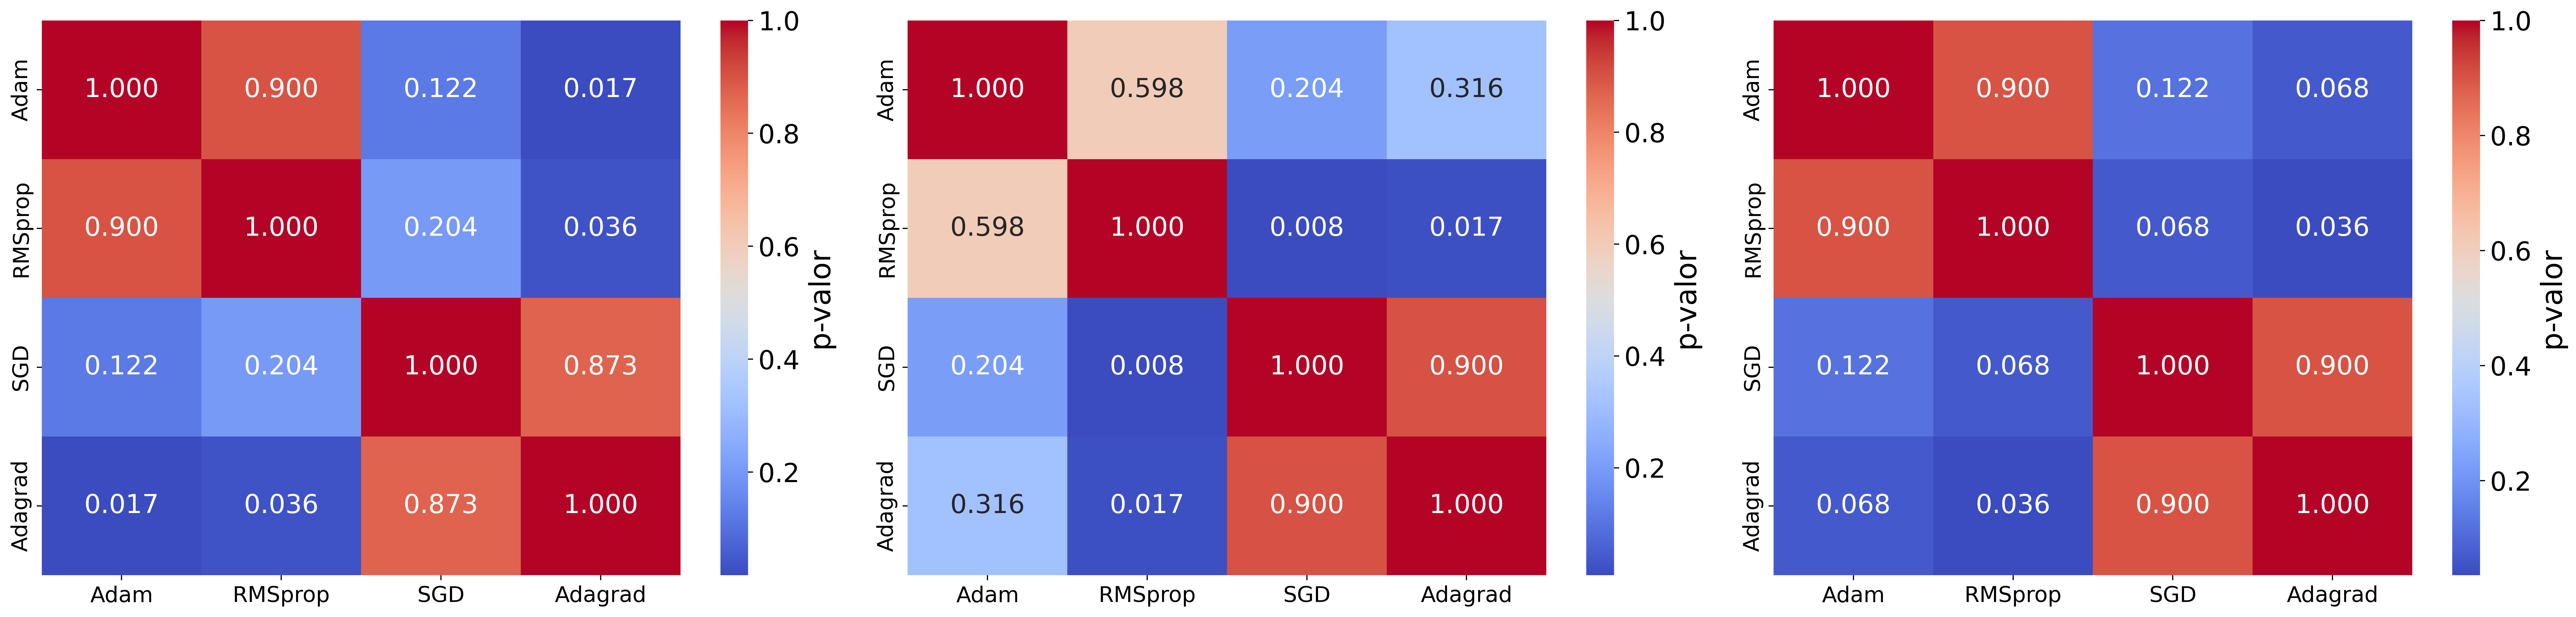

In [65]:
plt.figure(figsize=(25, 6), dpi=500)

# Iterar sobre os modelos
for idx, (_, row) in enumerate(friedman_results.iterrows()):
    if row['Significativo'] == 'Sim':
        # Criar subplot
        plt.subplot(1, 3, idx+1)
        
        # Coletar dados e realizar teste post-hoc de Nemenyi
        optimizer_data = {opt: results[row['Modelo']][opt]['accuracy'] 
                         for opt in ['Adam', 'RMSprop', 'SGD', 'Adagrad']}
        
        # Converter para DataFrame para o post-hoc
        optimizer_df = pd.DataFrame(optimizer_data)
        
        # Aplicar o teste post-hoc de Nemenyi
        posthoc_results = sp.posthoc_nemenyi_friedman(optimizer_df)
        print(posthoc_results)
        
        # Plotar o heatmap
        ax = sns.heatmap(posthoc_results, 
                         annot=True, 
                         cmap='coolwarm', 
                         fmt='.3f',
                         annot_kws={'size': 18},
                         cbar_kws={'label': 'p-valor'})  # Sem 'labelsize' aqui
        
        # Aumentar o tamanho da fonte do label da barra de cores (colorbar)
        cbar = ax.collections[0].colorbar
        cbar.set_label('p-valor', fontsize=20)  # Definir o tamanho do texto da barra de cores
        cbar.ax.tick_params(labelsize=18)       # Definir o tamanho da fonte dos ticks da barra de cores
        
        # plt.title(f'Teste Nemenyi - {row["Modelo"]}', fontsize=14)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


O MLP2 com RMSprop é a melhor combinação porque:

- Apresentou as melhores métricas (acurácia e F1-score)
- Teve os menores desvios padrão (maior estabilidade)
- Teve a evidência estatística mais forte (menor p-valor)
- RMSprop tem desempenho estatisticamente equivalente ao Adam
A arquitetura intermediária (MLP2) parece ter o melhor equilíbrio entre simplicidade e capacidade de aprendizado

In [67]:
best_model = 'model2'
best_optimizer = 'RMSprop'

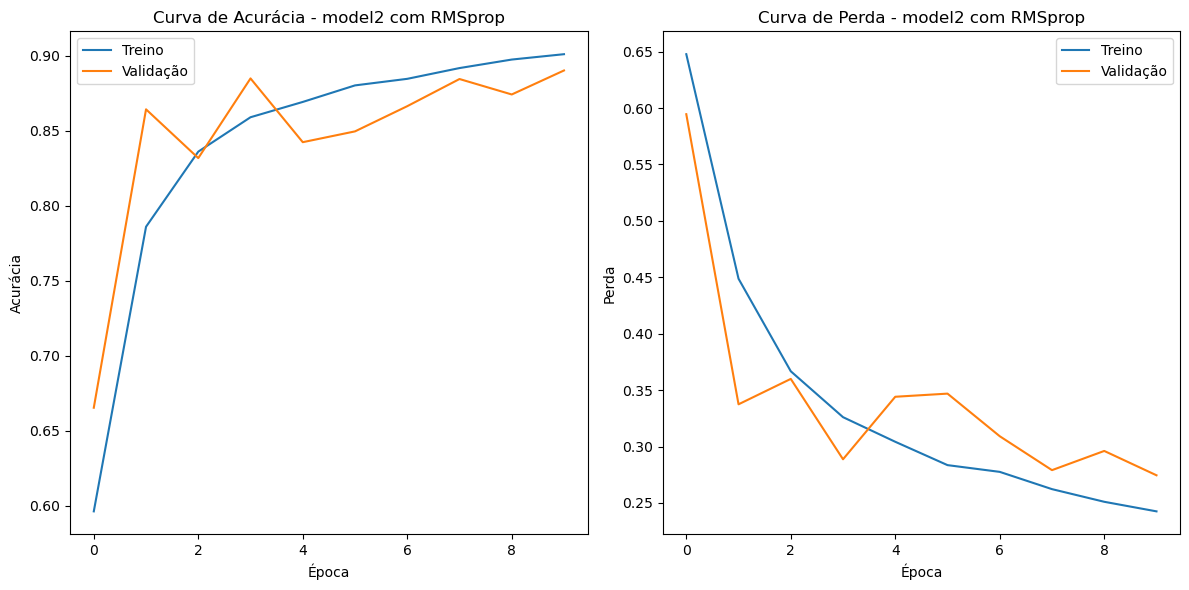

In [70]:
# Plotar a curva de aprendizado (acurácia e perda) para o melhor modelo
history = results[best_model][best_optimizer]['history']

plt.figure(figsize=(12, 6))

# Curva de acurácia
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Treino')
plt.plot(history['val_accuracy'], label='Validação')
plt.title(f'Curva de Acurácia - {best_model} com {best_optimizer}')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Curva de perda
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Treino')
plt.plot(history['val_loss'], label='Validação')
plt.title(f'Curva de Perda - {best_model} com {best_optimizer}')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

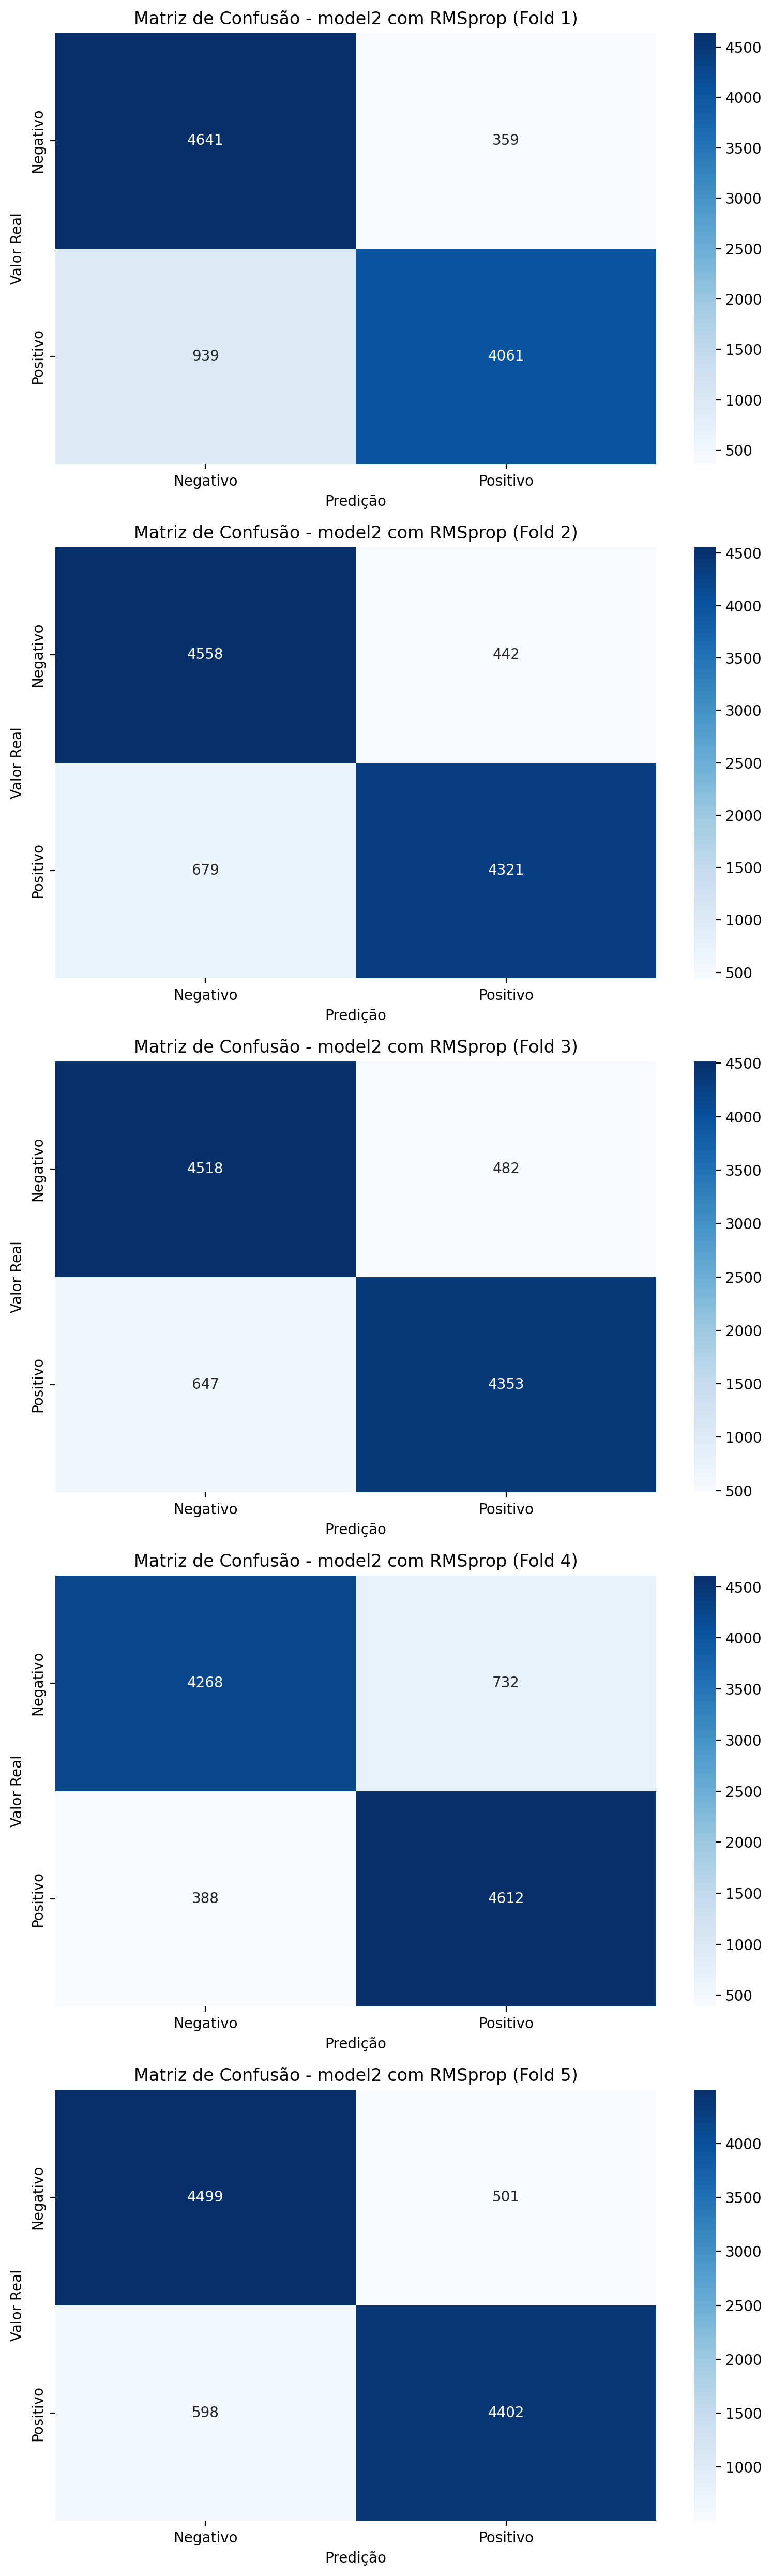

In [78]:
from sklearn.metrics import confusion_matrix

folds = len(results[best_model][best_optimizer]['predictions'])
plt.figure(figsize=(8, 5 * folds), dpi=200)

for i in range(folds):
    y_true, y_pred = results[best_model][best_optimizer]['predictions'][i]

    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(folds, 1, i + 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predição')
    plt.ylabel('Valor Real')
    plt.title(f'Matriz de Confusão - {best_model} com {best_optimizer} (Fold {i + 1})')

plt.tight_layout()
plt.show()